In [1]:
def matrix_unique_indices(parameter, header_letter):
    """
    :param parameter: variable that repeats itself in a grid (float or int)
    :param header_letter: select one letter from a to z to make reference to your parameter; this will be the header 
    (string)
    :return: a matrix in which the first line is the header, the second the actual value of the variable, and the 
             following indices in which this feature is repeated. 
    """

    import numpy as np

    unique_params = np.unique(parameter)

    indices_unique = []
    for i in range(unique_params.size):               # Looking at every unique z at each time (50 z's)
        indices_unique.append(header_letter+"_%d" % i)# Creating a list with the sequential number of each z
        indices_unique.append(unique_params[i])       # Adding the actual value of such redshift in the list above
        for j in range(parameter.size):               # Now looking at the entire redshift grid of all z's (2500)
            if unique_params[i] == parameter[j]:      # Comparing every z (from the 2500) with each unique z (1 of 50)
                indices_unique.append(j)              # If comparison true, the list will append the memory location
                                                                        # of the z's that are equal to each unique z
            else:
                continue                            # If not true, continue the loop for the next z within the same
            # unique z, until another unique z takes place
    new_matrix = np.array(indices_unique).reshape(unique_params.size,unique_params.size+2).T
    # Finally, my list will be enormous, incorporating z_number (1 to 50), z value, and 50 memory locations where such
    # z appears in the entire 2500 grid of z's ; then transforming all that into a matrix that 'makes sense'.
    return (new_matrix)

In [2]:
def rearranging_other_features(new_matrix, mean, percentile02, percentile25, percentile50, percentile75, percentile97,
                               standard_deviation, parameter_name):
    """
    
    :param new_matrix: matrix with the indices pointing to the repeated values of the unique parameters.
    :param mean: array of all means of the original fit (say 2500)
    :param percentile02: array of all 02.5th percentile of the original fit file (say 2500)
    :param percentile25: idem for the 25.0th percentile
    :param percentile50: idem for the 50.0th percentile
    :param percentile75: idem for the 75.0th percentile
    :param percentile97: idem for the 97.5th percentile
    :param standard_deviation: idem for the standard deviation.
    :return: all parameters and the final matrix with the mean of all the aforementioned parameters for each unique 
    parameter inserted in the new_matrix.
    """

    import numpy as np
    import pandas as pd

    sd_i = []
    matrix = []
    mean_i = []
    percentile02_i = []
    percentile25_i = []
    percentile50_i = []
    percentile75_i = []
    percentile97_i = []
    
    d = 6

    for k in range(new_matrix[2:, 0].size):                # same as unique reshifts.size - we are looking at each z
        column = new_matrix[:, k]
        header = column[1:2]
        indices_col = column[2:]
        mean_probability = list(column[1:2])                # Maintaining the original header
        for m in indices_col:                               # Grouping the results that refer to repeated parameters
            mean_i.append(mean[int(m)])                     # Appending the mean of all the indices of column "m"
            percentile02_i.append(percentile02[int(m)])     # Appending the  2.5nd percentile of all indices of col "m"
            percentile25_i.append(percentile25[int(m)])     # Appending the 25.0th percentile of all indices of col "m"
            percentile50_i.append(percentile50[int(m)])     # Appending the 50.0th percentile of all indices of col "m"
            percentile75_i.append(percentile75[int(m)])     # Appending the 75.0th percentile of all indices of col "m"
            percentile97_i.append(percentile97[int(m)])     # Appending the 97.5th percentile of all indices of col "m"
            sd_i.append(standard_deviation[int(m)])         # Appending the standard deviation of all indices of col "m"
        prob = round(np.mean(np.array(mean_i).astype(float)), d)         # Mean of the "mean"
        p02 = round(np.mean(np.array(percentile02_i).astype(float)), d)  # Mean of the 2.5nd percentile for all indices in cal "m"
        p25 = round(np.mean(np.array(percentile25_i).astype(float)), d)  # ...and so forth.
        p50 = round(np.mean(np.array(percentile50_i).astype(float)), d)
        p75 = round(np.mean(np.array(percentile75_i).astype(float)), d)
        p97 = round(np.mean(np.array(percentile97_i).astype(float)), d)
        sdv = round(np.mean(np.array(sd_i).astype(float)), d)

        mean_probability.append(prob)          # Appending each parameter at a time, so they can be joined horizontally
        mean_probability.append(p02)
        mean_probability.append(p25)
        mean_probability.append(p50)
        mean_probability.append(p75)
        mean_probability.append(p97)
        mean_probability.append(sdv)
        matrix.append(mean_probability)        # The final matrix

        remodled_data = {}
        remodled_data[parameter_name] = np.array(matrix).T[0]
        remodled_data['mean']         = np.array(matrix).T[1]
        remodled_data['perc_02.5%']   = np.array(matrix).T[2]
        remodled_data['perc_25.0%']   = np.array(matrix).T[3]
        remodled_data['perc_50.0%']   = np.array(matrix).T[4]
        remodled_data['perc_75.0%']   = np.array(matrix).T[5]
        remodled_data['perc_97.5%']   = np.array(matrix).T[6]
        remodled_data['std']          = np.array(matrix).T[7]
        remodled_data_df = pd.DataFrame(remodled_data)

    return (remodled_data_df)

# Libaries

In [3]:
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import seaborn            as sns
import pystan
import os
from mpl_toolkits.mplot3d import Axes3D

# Dataset

In [4]:
results    = pd.read_csv('./Results/fit_results_sharedprior.csv')
posteriors = pd.read_csv('./Results/betas_sharedprior.csv')
entire_fit = pd.read_csv('./Results/entirefit_sharedpriors.csv')

In [5]:
figs_path = './../../Figs/FigsSharedPrior/'

In [6]:
dimensions = posteriors.columns.values.reshape(5,5)
rows       = dimensions[:,0].size
columns    = dimensions[0,:].size

In [7]:
whan_classes = ['Not classified', 'Retired/Passive', 'wAGN', 'sAGN', 'SF']
palette      = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8','#984ea3']
figsize      = (20, 20)
alpha        = 0.4

/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


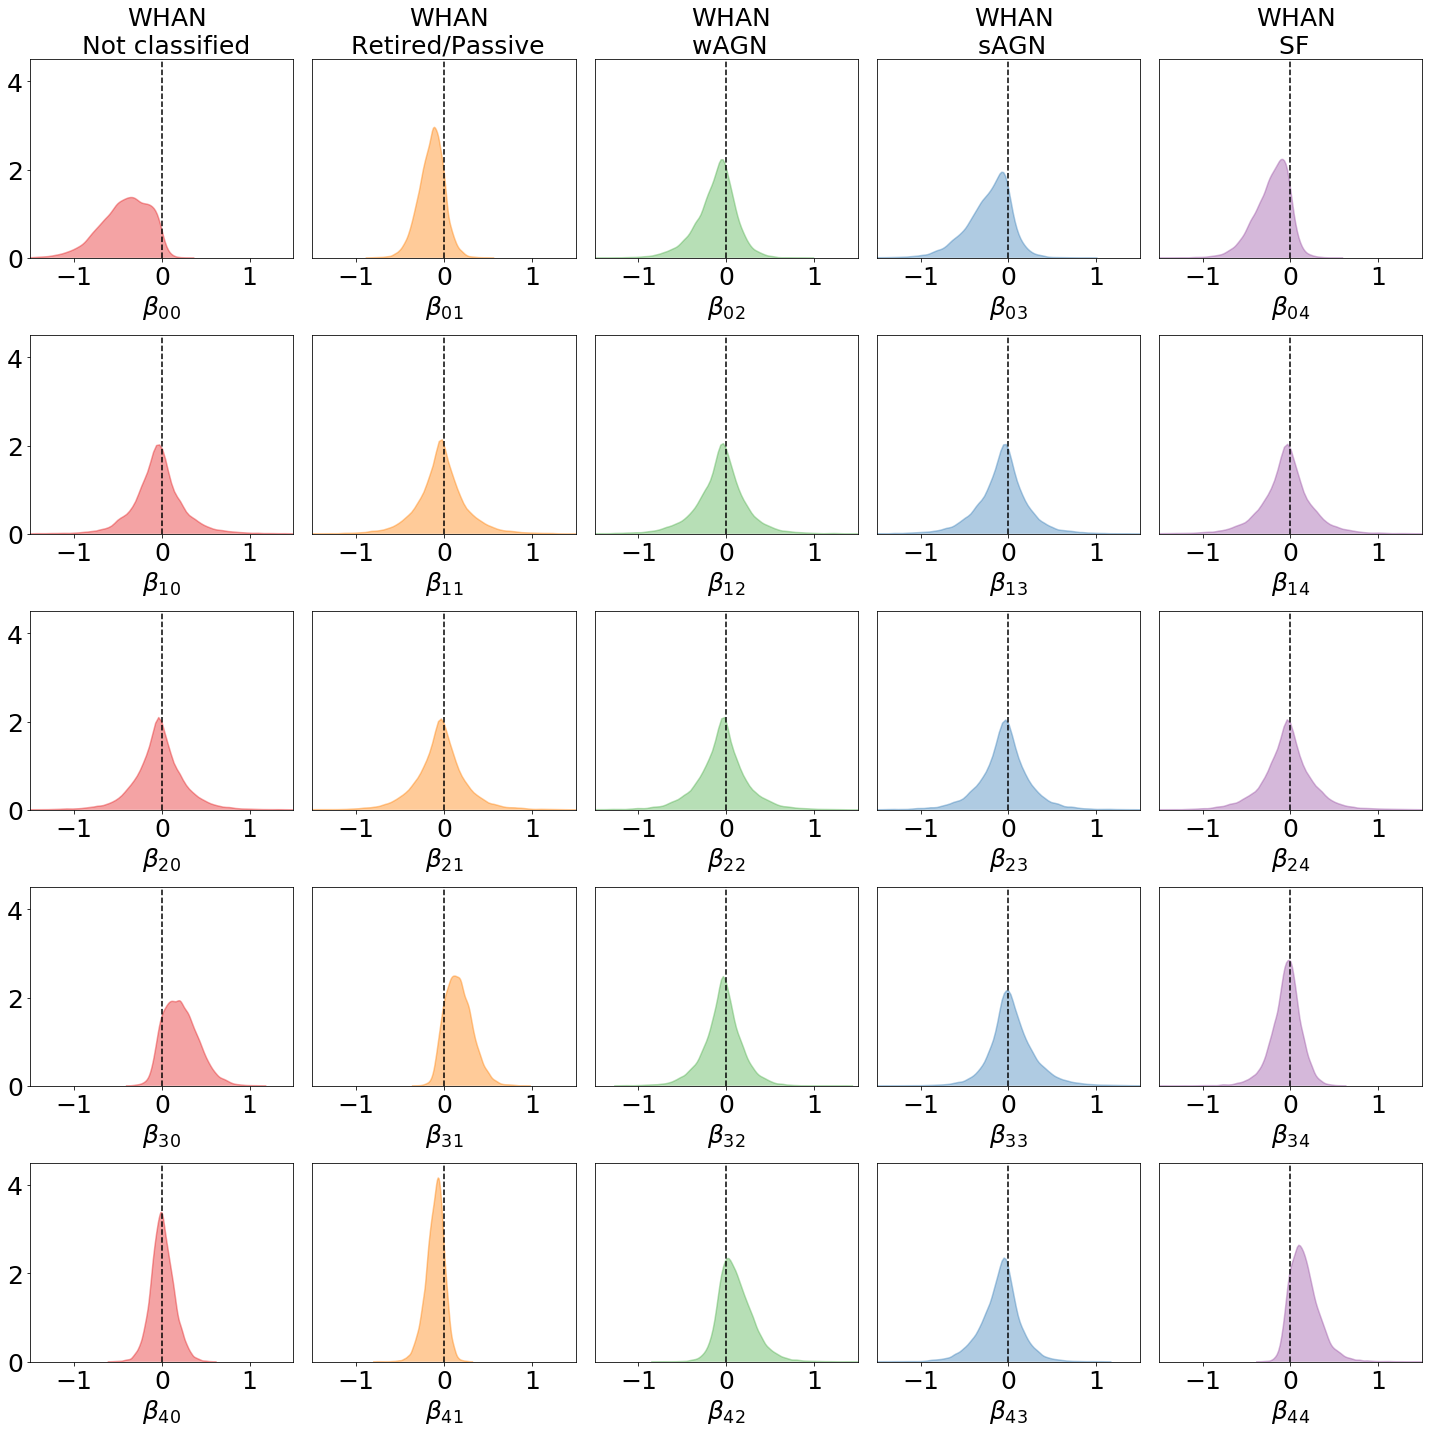

In [8]:
plt.subplots(figsize=figsize)
position = 0
for i in range(rows):
    for j in range(columns):
        position+=1
        plot = plt.subplot(rows, columns, position)
        posterior_temp = posteriors.columns.values.reshape(rows, columns)[i,j]
        sns.kdeplot(posteriors["%s" % posterior_temp].values, shade=True, alpha=alpha, color=palette[j])
        plt.axvline(x=0, linestyle="--", color='black')
        plt.tick_params('both', labelsize='25')
        plt.xlabel(r"$\beta_{%d%d}$" % (i,j), fontsize=25)
        plt.xlim([-1.5,1.5])
        plt.ylim([0,4.5])
        if (i==0):
            plt.title("$\,$ WHAN \n %s" % whan_classes[j], fontsize=25)
            if (j!=0): 
                plot.yaxis.set_visible(False)
            else: 
                plot.yaxis.set_visible(True)
        elif(i>=0)*(j==0): 
            plot.yaxis.set_visible(True)
        else: 
            plot.yaxis.set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, "25betas.png"))
plt.savefig(os.path.join(figs_path, "25betas.pdf"))
plt.show()

## Separating data by probability (hence, by WHAN class)

In [9]:
entire_fit

,chain,chain_idx,warmup,accept_stat__,energy__,n_leapfrog__,stepsize__,treedepth__,divergent__,"beta[1,1]",...,eta05[892],eta05[893],eta05[894],eta05[895],eta05[896],eta05[897],eta05[898],eta05[899],eta05[900],lp__
0,1,1,0,0.986013,323.949724,15,0.159867,4,0,-0.262989,...,0.338955,0.338929,0.338941,0.338990,0.339076,0.339199,0.339359,0.339557,0.339791,-312.828417
1,1,2,0,0.956442,329.501732,15,0.159867,4,0,-0.501811,...,-0.469019,-0.469874,-0.470787,-0.471757,-0.472784,-0.473869,-0.475011,-0.476211,-0.477468,-314.399855
2,1,3,0,1.000000,323.810331,15,0.159867,4,0,0.024087,...,-0.020066,-0.021805,-0.023561,-0.025333,-0.027120,-0.028924,-0.030744,-0.032579,-0.034431,-308.512895
3,1,4,0,0.735100,323.079841,15,0.159867,4,0,-0.515956,...,-0.078499,-0.078760,-0.079032,-0.079316,-0.079610,-0.079917,-0.080234,-0.080563,-0.080903,-309.206504
4,1,5,0,0.859485,328.190395,31,0.159867,5,0,-0.077803,...,0.103438,0.102516,0.101524,0.100462,0.099330,0.098128,0.096856,0.095514,0.094103,-315.666540
5,1,6,0,0.801261,333.471965,31,0.159867,4,0,-0.525153,...,-0.176899,-0.174978,-0.172976,-0.170892,-0.168726,-0.166478,-0.164149,-0.161738,-0.159246,-323.331067
6,1,7,0,0.996556,333.158054,31,0.159867,4,0,-0.542828,...,-0.086047,-0.085880,-0.085747,-0.085647,-0.085580,-0.085547,-0.085548,-0.085582,-0.085649,-317.587097
7,1,8,0,0.987000,330.089876,15,0.159867,4,0,-0.316204,...,0.175464,0.178150,0.180884,0.183667,0.186498,0.189377,0.192304,0.195280,0.198305,-315.086731
8,1,9,0,0.995224,320.522138,15,0.159867,4,0,-0.031845,...,-0.113068,-0.114157,-0.115257,-0.116367,-0.117487,-0.118617,-0.119757,-0.120908,-0.122068,-310.003129
9,1,10,0,0.895147,322.469122,31,0.159867,4,0,-0.105522,...,0.014320,0.012161,0.010007,0.007858,0.005714,0.003575,0.001441,-0.000688,-0.002812,-306.654938


In [10]:
entire_fit.keys()[0:10]

Index([u'chain', u'chain_idx', u'warmup', u'accept_stat__', u'energy__',
       u'n_leapfrog__', u'stepsize__', u'treedepth__', u'divergent__',
       u'beta[1,1]'],
      dtype='object')

In [11]:
entire_fit.keys()[10:40]

Index([u'beta[2,1]', u'beta[3,1]', u'beta[4,1]', u'beta[5,1]', u'beta[1,2]',
       u'beta[2,2]', u'beta[3,2]', u'beta[4,2]', u'beta[5,2]', u'beta[1,3]',
       u'beta[2,3]', u'beta[3,3]', u'beta[4,3]', u'beta[5,3]', u'beta[1,4]',
       u'beta[2,4]', u'beta[3,4]', u'beta[4,4]', u'beta[5,4]', u'beta[1,5]',
       u'beta[2,5]', u'beta[3,5]', u'beta[4,5]', u'beta[5,5]', u'sigma', u'mu',
       u'prob01[1]', u'prob01[2]', u'prob01[3]', u'prob01[4]'],
      dtype='object')

In [ ]:
df01

In [ ]:
df01, df02, df03, df04, df05 = np.array_split(results, 5)

In [ ]:
parameter = df01['parameter'].astype(str)
redshifts = df01['Z'].astype(float)
masses    = df01['LOG_STELLAR_MASS'].astype(float)
mean      = df01['mean'].astype(float)
perc_2_5  = df01['2.5%'].astype(float)
perc_25   = df01['25%'].astype(float)
perc_50   = df01['50%'].astype(float)
perc_75   = df01['75%'].astype(float)
perc_97_5 = df01['97.5%'].astype(float)
sd        = df01['sd'].astype(float)

In [ ]:
idx_masses    = np.where(masses.values == 9.)
sub_redshifts = redshifts.values[idx_masses]
sub_mean      = mean.values[idx_masses]

In [ ]:
plt.plot(sub_redshifts, sub_mean[idx_mass],'.')
plt.show()

In [ ]:
plt.plot(df01["LOG_STELLAR_MASS"], mean,    '.', label="Probability", alpha=0.6)
plt.plot(df01["LOG_STELLAR_MASS"], perc_25, '.', label="25%",         alpha=0.6)
plt.plot(df01["LOG_STELLAR_MASS"], perc_75, '.', label="75%",         alpha=0.6)
plt.legend(loc='best')
plt.xlabel("Log M$_*$")
plt.ylabel("Prob")
plt.savefig('./Results/mass_temp.png')
plt.show()

In [ ]:
idx_z = np.where(redshifts.values==np.unique(redshifts)[0])

plt.plot(df01["LOG_STELLAR_MASS"].values[idx_z], mean.values[idx_z],    '.', label="Probability", alpha=0.6)
plt.plot(df01["LOG_STELLAR_MASS"].values[idx_z], perc_25.values[idx_z], '.', label="25%",         alpha=0.6)
plt.plot(df01["LOG_STELLAR_MASS"].values[idx_z], perc_75.values[idx_z], '.', label="75%",         alpha=0.6)
plt.legend(loc='best')
plt.xlabel("Log M$_*$")
plt.ylabel("Prob")
plt.savefig('./Results/mass_temp_onez.png')
plt.show()

In [ ]:
idx_mass01 = np.where((masses==np.unique(masses)[1]))
prob_mass01 = mean.values[idx_mass01]
print masses.values[idx_mass01]
print prob_mass01, np.unique(prob_mass01).size
print redshifts.values[idx_mass01], np.unique(redshifts.values[idx_mass01]).size

In [ ]:
print redshifts.values[idx_mass][0:4]
print mean.values[idx_mass][0:4]

In [ ]:
plt.plot(redshifts.values[idx_mass], mean.values[idx_mass], '.')
plt.show()

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
# plt.scatter(redshift, sersic_gal, mean, c = '#feb24c', alpha=0.7)
ax.plot_trisurf(df01["Z"], df01["LOG_STELLAR_MASS"], df01["mean"], color='#a6611a', alpha=0.8, linewidth=0, antialiased=False)
ax.set_xlabel("\n z", fontsize=14)
ax.set_ylabel("\n Log M$_*$ (M$_\odot$)", fontsize=14)
ax.set_zlabel("\n Probability of \n UV upturn", fontsize=14)
for t in ax.yaxis.get_major_ticks(): 
    t.label.set_fontsize(10)
ax.set_yticks([9.75, 10.25, 10.75, 11.25, 11.75])
ax.view_init(elev=22., azim=315)
# ax.zaxis.set_rotate_label(False)
# plt.savefig('./../../Figs/logit3D_grid.pdf', dpi=100)

# for ii in xrange(180,360,10):
#     ax.view_init(elev=10., azim=ii)
#     plt.savefig("./Results/movie_short/movie_0%d_0.png" % ii)
    
# plt.savefig("./movie_0%d.png" % 359)

plt.show()

In [ ]:
# unique_z = matrix_unique_indices(df01["Z"].values, 'Z')

In [ ]:
# out = rearranging_other_features(new_matrix=unique_z, mean=mean, percentile02=perc_2_5, percentile25=perc_25, 
#                                  percentile50=perc_50, percentile75=perc_75, percentile97=perc_97_5, 
#                                  standard_deviation=sd, parameter_name="Z")

In [ ]:
# out

In [ ]:
np.unique(df01["Z"].values)

In [ ]:
np.unique(df01["mean"].values)

In [ ]:
idx = np.where(np.unique(df01["mean"].values))

In [ ]:
plt.plot(df01["Z"].values.astype(float)[idx], df01["mean"].values.astype(float)[idx], '.')
plt.show()